# Import Libraries and Create Base Dataframes

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#Read parquet file
df = pd.read_parquet('zippedData/merged_data.parquet')

In [3]:
# Create dataframe with only values from 2010 to present
recent = df.loc[df.release_date.dt.year >= 2010]

# Create dataframe expanded along genres using pd.explode
expanded_genres = recent.copy().explode('genres')

## Median Return on Investment by Genre

In [4]:
# Create dataframe grouped by genre aggregated by median value
# Sort values by median ROI, then reset index to bring genres back to column
median_ROI_by_genre = expanded_genres.groupby(["genres"]).median().sort_values("ROI", ascending = False).reset_index()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


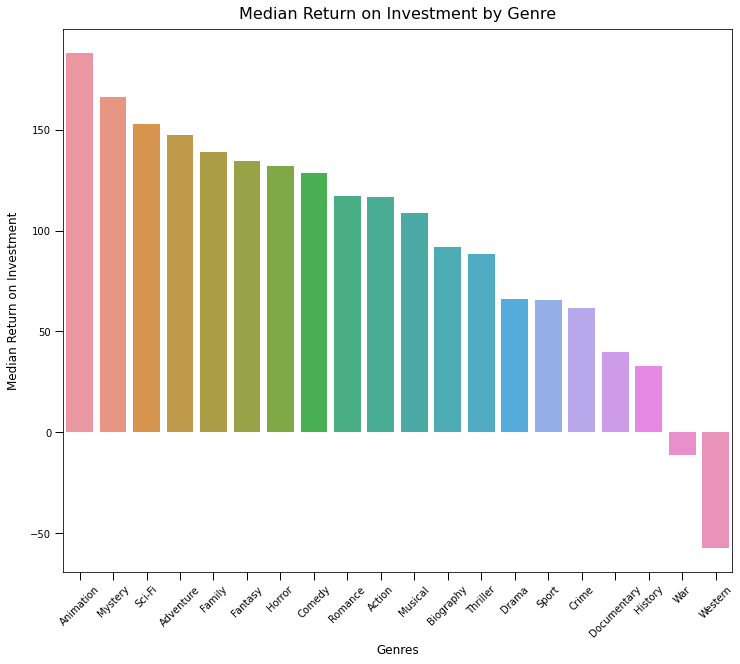

In [5]:
# Create a bar plot of median ROI by genre
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (12, 10))

# Set color palette
# sns.set_palette('husl')

# Create seaborn barplot where genre not equal to 'None'
sns.barplot(data = median_ROI_by_genre.loc[median_ROI_by_genre.genres != 'None'],
            x = "genres",
            y = "ROI",
            ax = ax)

# Set axis labels and title
ax.set_xlabel('Genres',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 5)

ax.set_ylabel('Median Return on Investment',
             fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_title('Median Return on Investment by Genre',
            fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)



# Configure tick labels and ticks
plt.xticks(rotation = 45)

ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 10,
               length = 8,
               width = 1)

# Set font for tick labels on both axes
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")

# Save figure to png
plt.savefig('./images/median_roi_by_genre.png')

## Distribution of ROI by Genre

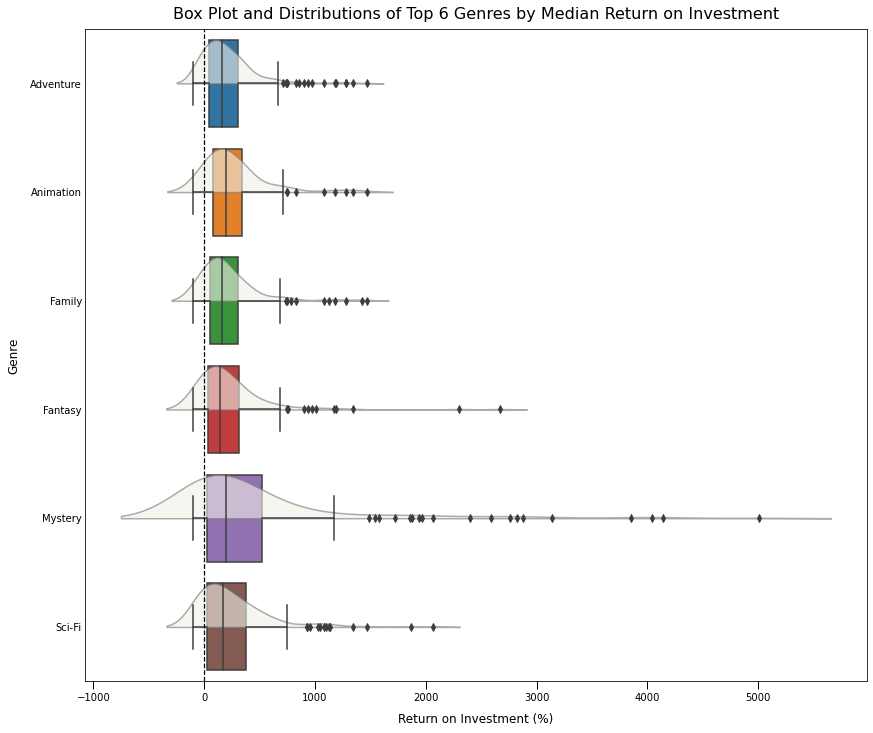

In [6]:
# Create dataframe grouped by genres with median ROI, median product budget, and a count of titles in the genre
groupby_genres_median = expanded_genres.groupby('genres').agg({'ROI': 'median',
                                                               'prod_budget': 'median',
                                                               'title': 'count'})

# Recast title column as int for use in further filtering
groupby_genres_median.title = groupby_genres_median.title.astype(int)

# Filter by genres that have at least 75 titles in data set
groupby_genres_median = groupby_genres_median.loc[groupby_genres_median.title >= 75]

# Create a dataframe that represents the top 6 genres by median ROI
top_6_by_median = groupby_genres_median.nlargest(6, 'ROI')

# Create a dataframe grouped by genres then ROI, reset index to turn back into a dataframe rather than groupby object
# This allows grouping of data without having to use aggregate functions
groupby_genres_ROI = expanded_genres.groupby(['genres', 'ROI']).first()
groupby_genres_ROI = groupby_genres_ROI.reset_index()

# Create dataframes representing the top 9 genres and the 6 genres by median (less influenced by outliers)
top_6_genres_by_median_raw_ROI = groupby_genres_ROI.loc[groupby_genres_ROI.genres.isin(list(top_6_by_median.index))]

# Create an overlaid boxplot and violinplot for the top 6 genres by median to show distributions
# Declare fig, ax objects
fig, ax = plt.subplots(figsize=(14,12))

# Create seaborn boxplot
sns.boxplot(data = top_6_genres_by_median_raw_ROI,
            y = 'genres',
            x = 'ROI',
            orient = 'h',
            ax = ax)

# Create seaborn violinplot, forcibly creating a half violin by hueing only on true
sns.violinplot(data=top_6_genres_by_median_raw_ROI,
               orient='h',
               y='genres',
               x='ROI',
               inner='box',
               hue=True,
               hue_order = [True,False],
               split=True,
               color='#e7f294',
               ax=ax);

# Suppress legend created due to tricking violinplot to create half violin
ax.legend_ = None

# Set opacity of violinplot to 0.6
plt.setp(ax.collections, alpha=0.6)

# Create vertical line at ROI = 0 for clarity
ax.axvline(x=0, c='k', linestyle='--', linewidth=1.25);

# Set axis labels and title
ax.set_xlabel('Return on Investment (%)',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_ylabel('Genre',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_title('Box Plot and Distributions of Top 6 Genres by Median Return on Investment',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)

# Set tick labels
ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 10,
               length = 8,
               width = 1)

ax.tick_params(axis = 'y', length = 0, labelsize = 10)

# Set font for tick labels on both axes
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")

# Save figure to png
plt.savefig('./images/distribution_of_roi_by_genre.png')

## Changes Over Time in Median ROI by Genre

In [7]:
# Create dataframe exploded along genres for all years - filter by specific genres that are interesting
expanded_genres_all = df.copy().explode('genres')
expanded_genres_all = expanded_genres_all.loc[expanded_genres_all.genres.isin(['Adventure', 'Family', 'Sci-Fi', 'Mystery', 'Horror', 'Thriller','Romance', 'Animation'])]

# Group by years then genres, aggregate by median
median_ROI_all = expanded_genres_all.groupby(['year','genres'])['ROI'].median().reset_index()

In [8]:
# Create dataframe of median ROI by year (not broken up by genre)
ROI_by_year = expanded_genres_all.groupby('year').ROI.median()

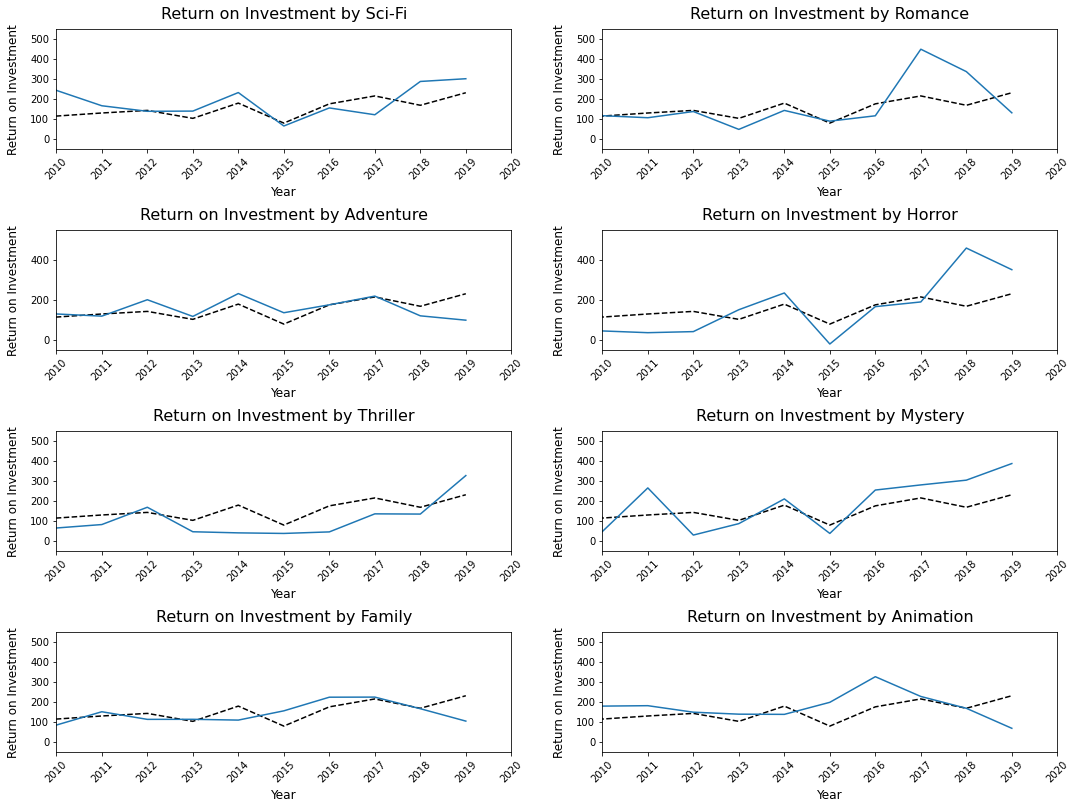

In [9]:
# Plot all the top 6 genre medians between 2011 and 2019
# Declare fig, ax objects, 4 by 2 subplots
fig, ax = plt.subplots(4,2,figsize = (16,12))

# Declare tight_layout with padding to prevent label overlap
plt.tight_layout(pad = 6)

#Loop through unique genre names to plot to the 3 x 2 ax matrix
for index, gen in enumerate(list(median_ROI_all.genres.unique())):
    # Assign axis
    axis = ax[index % 4][index // 4]
    
    # Create a seaborn lineplot using mean ROI for all genres as comparison
    sns.lineplot(x = ROI_by_year.index, y = ROI_by_year.values, color = 'black', linestyle = '--', ax = axis);
    
    # Create a seaborn lineplot using genre mean ROI
    sns.lineplot(data = median_ROI_all,
                 x = 'year',
                 y = median_ROI_all.loc[median_ROI_all.genres == gen].ROI,
                 ax = axis);
    
    # Set axis limits
    axis.set_xlim([2010,2020])
    axis.set_ylim([-50,550])
    
    # Set axis labels and titles
    axis.set_xlabel('Year',
                    fontfamily = 'Arial',
                    fontsize = 12,
                    labelpad = 5)
    
    axis.set_ylabel('Return on Investment',
                    fontfamily = 'Arial',
                    fontsize = 12,
                    labelpad = 10)
    
    axis.set_title(f'Return on Investment by {gen}',
                   fontfamily = 'Arial',
                   fontsize = 16,
                   pad = 10)
    
    axis.xaxis.set_major_locator(plt.MultipleLocator(1))
    
    
    #Loop through each axis tick and rotate
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontname("Arial")
    
    for tick in axis.get_yticklabels():
        tick.set_fontname("Arial")

# Save figure to png
plt.savefig('./images/change_in_roi_by_genre.png')

## Top 15 Directors from Best Genres

In [10]:
# Explode expanded_genres by director
expanded_director = expanded_genres.copy().explode('director')

In [11]:
# Slice expanded_director by genres in the top 6 genres by median ROI
expanded_director_top_genres = expanded_director.loc[expanded_director.genres.isin(list(top_6_by_median.index))]

# Sort by genres, director, ROI for further processing, drop unnecessary columns
expanded_director_top_genres = expanded_director_top_genres.sort_values(['genres', 'director', 'ROI'])
expanded_director_top_genres = expanded_director_top_genres[['genres', 'director','title', 'ROI']]

# Create empty series to populate
ROI_normed_series_directors = pd.Series(dtype = 'float64')

# For each genre, select the mean ROI, and then apply normalization function to ROI row
# Append data to ROI_normed_series_directors to build new column
for genre in sorted(list(expanded_director_top_genres.genres.unique())):
    frame_slice = expanded_director_top_genres.loc[expanded_director_top_genres.genres == genre] 
    genre_mean = frame_slice.ROI.mean()
    temp_series = frame_slice.ROI.apply(lambda x: (x - genre_mean)/(genre_mean))
    ROI_normed_series_directors = pd.concat([ROI_normed_series_directors, temp_series])

# Create new column named 'ROI_normed' using built series
expanded_director_top_genres['ROI_normed'] = ROI_normed_series_directors

# Create empty dataframe to populate
top_5_directors_top_genres = pd.DataFrame()

# For each genre, select the top 5 directors by ROI_normed for the genre
# Append data to top_5_directors_top_genres
for genre in sorted(list(expanded_director_top_genres.genres.unique())):
    frame_slice = expanded_director_top_genres.loc[expanded_director_top_genres.genres == genre]
    temp_frame = frame_slice.groupby('director').agg({'ROI_normed': 'mean', 'genres': 'first'}).nlargest(5, 'ROI_normed')
    top_5_directors_top_genres = pd.concat([top_5_directors_top_genres, temp_frame])
    
# Select the top 15 directors out of top 5 directors for each genre
top_15_directors = top_5_directors_top_genres.reset_index().nlargest(15, 'ROI_normed')

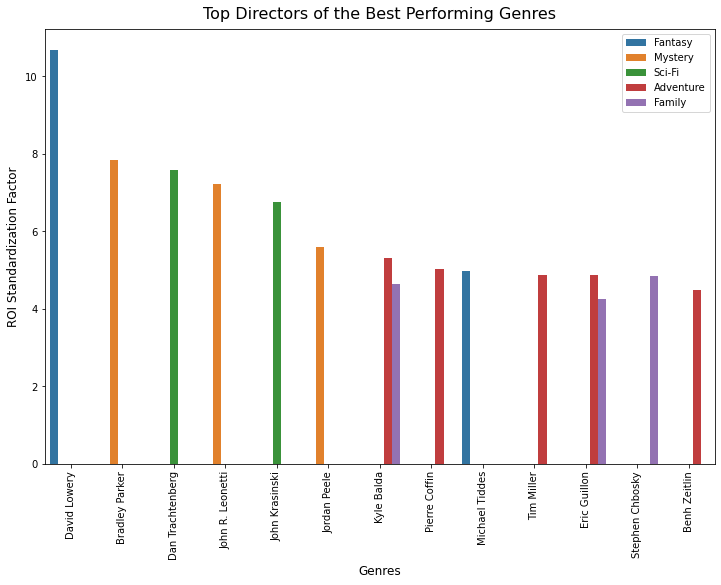

In [12]:
# Plot the top 15 directors of the top genres
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (12,8))

# Create seaborn barplot
sns.barplot(data = top_15_directors,
            x = 'director',
            y = 'ROI_normed',
            hue = 'genres');

# Set axis labels and title
ax.set_xlabel('Genres',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 5)

ax.set_ylabel('ROI Standardization Factor',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 5)

ax.set_title('Top Directors of the Best Performing Genres',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)

# Configure ticks and tick labels
plt.xticks(rotation = 90)

#Loop through each axis tick and rotate
for tick in axis.get_xticklabels():
    tick.set_fontname("Arial")

for tick in axis.get_yticklabels():
    tick.set_fontname("Arial")

# Move legend to top right
plt.legend(loc = 'upper right');

# Save figure to png
plt.savefig('./images/top_directors_by_genre.png')

## Top 15 Writers from Best Genres

In [13]:
# Explode expanded_genres by writer
expanded_writer = expanded_genres.copy().explode('writer')

In [14]:
# Slice expanded_writer by genres in the top 6 genres by median ROI
expanded_writer_top_genres = expanded_writer.loc[expanded_writer.genres.isin(list(top_6_by_median.index))]

# Sort by genres, writer, ROI for further processing, drop unnecessary columns
expanded_writer_top_genres = expanded_writer_top_genres.sort_values(['genres', 'writer', 'ROI'])
expanded_writer_top_genres = expanded_writer_top_genres[['genres', 'writer','title', 'ROI']]

# Create empty series to populate
ROI_normed_series_writers = pd.Series(dtype = 'float64')

# For each genre, select the mean ROI, and then apply normalization function to ROI row
# Append data to ROI_normed_series_writers to build new column
for genre in sorted(list(expanded_writer_top_genres.genres.unique())):
    frame_slice = expanded_writer_top_genres.loc[expanded_writer_top_genres.genres == genre] 
    genre_mean = frame_slice.ROI.mean()
    temp_series = frame_slice.ROI.apply(lambda x: (x - genre_mean)/(genre_mean))
    ROI_normed_series_writers = pd.concat([ROI_normed_series_writers, temp_series])

# Create new column named 'ROI_normed' using built series
expanded_writer_top_genres['ROI_normed'] = ROI_normed_series_writers

# Create empty dataframe to populate
top_5_writers_top_genres = pd.DataFrame()

# For each genre, select the top 5 writers by ROI_normed for the genre
# Append data to top_5_writers_top_genres
for genre in sorted(list(expanded_writer_top_genres.genres.unique())):
    frame_slice = expanded_writer_top_genres.loc[expanded_writer_top_genres.genres == genre]
    temp_frame = frame_slice.groupby('writer').agg({'ROI_normed': 'mean', 'genres': 'first'}).nlargest(5, 'ROI_normed')
    top_5_writers_top_genres = pd.concat([top_5_writers_top_genres, temp_frame])
    
# Select the top 15 writers out of top 5 writers for each genre
top_15_writers = top_5_writers_top_genres.reset_index().nlargest(15, 'ROI_normed')

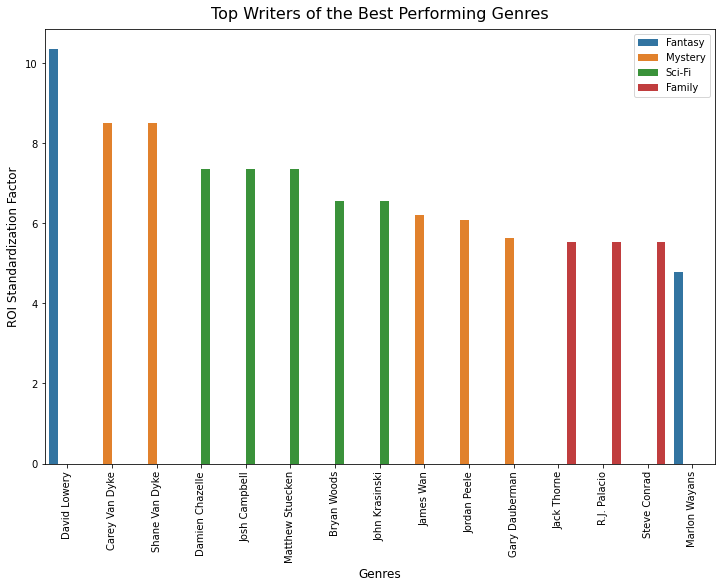

In [15]:
# Plot the top 15 writers of the top genres
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (12,8))

# Create seaborn barplot
sns.barplot(data = top_15_writers,
            x = 'writer',
            y = 'ROI_normed',
            hue = 'genres');

# Set axis labels and title
ax.set_xlabel('Genres',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 5)

ax.set_ylabel('ROI Standardization Factor',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 5)

ax.set_title('Top Writers of the Best Performing Genres',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)

# Configure ticks and tick labels
plt.xticks(rotation = 90)

#Loop through each axis tick and rotate
for tick in axis.get_xticklabels():
    tick.set_fontname("Arial")

for tick in axis.get_yticklabels():
    tick.set_fontname("Arial")

# Move legend to top right
plt.legend(loc = 'upper right');

# Save figure to png
plt.savefig('./images/top_writers_by_genre.png')

## Runtime vs. ROI

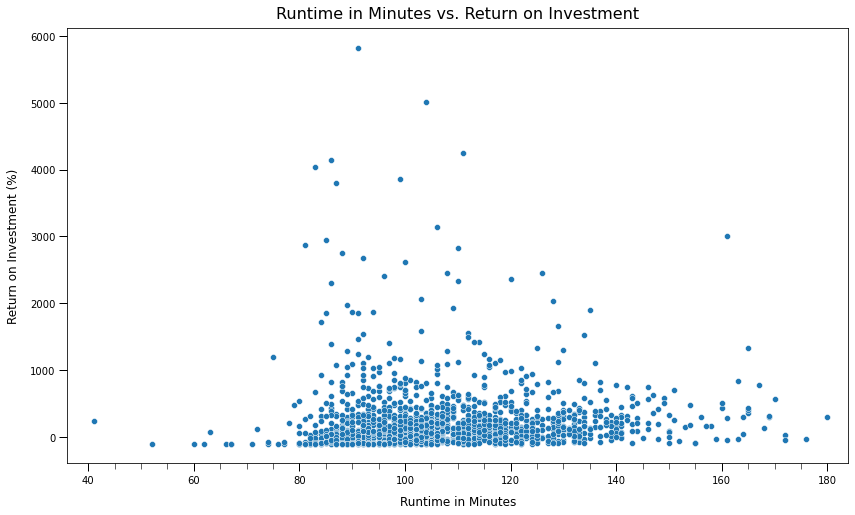

In [16]:
# Create seaborn scatterplot of runtime_min vs. ROI
# Not much semblance of correlation - if you are between ~90 and ~135 minutes (which is almost every movie), you make money
# Runtimes are all pretty close, the spread is not significant enough to try to separate into categorical "bins"

# Declare fig, ax objects as subplots
fig, ax = plt.subplots(figsize = (14, 8))

# Create seaborn scatterplot
sns.scatterplot(data = recent,
                x = 'runtime_min',
                y = 'ROI',
               ax = ax);

# Set axis labels and title
ax.set_xlabel('Runtime in Minutes',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_ylabel('Return on Investment (%)',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_title('Runtime in Minutes vs. Return on Investment',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)

# Set boundaries for x-axis
ax.set_xlim([36, 184])

# Turn on minor ticks, set tick parameters
ax.minorticks_on()
ax.yaxis.set_tick_params(which = 'minor', left = False)

ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 10,
               length = 8,
               width = 1)

ax.tick_params(axis = 'both',
               which = 'minor',
               length = 6)

# Set font for tick labels on both axes
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")

# Save figure to png
plt.savefig('./images/runtime_and_roi.png')